In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [3]:
torch.cuda.empty_cache()

In [5]:
class dehazer(): 

    def __init__(self, IMG_SIZE, LABEL_DIR, LABEL_NAME):
        self.IMG_SIZE = IMG_SIZE
        self.LABEL_DIR = LABEL_DIR
        self.LABEL_NAME = LABEL_NAME
        self.training_data = []

    def make_training_data(self):
        NUM_IMAGES = len(os.listdir(self.LABEL_DIR))
        for i in tqdm(range(1, NUM_IMAGES+1)):
            f = f"{str(i).zfill(2)}_indoor_{self.LABEL_NAME}.jpg"  # Adjusted file name format
            path = os.path.join(self.LABEL_DIR, f)
            if not os.path.exists(path):
                print(f"Image file at {path} does not exist.")
                continue
            img = cv2.imread(path)
            if img is None:
                print(f"Image at {path} could not be loaded.")
                continue
            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
            self.training_data.append(np.array(img))
        np.save(f'{self.LABEL_NAME}.npy', self.training_data)

In [6]:
REBUILD_DATA=True
try:     
    IMG_SIZE=256
    gt_dir='../minor_project/input/GT' 
    hazy_dir='../minor_project/input/hazy' 
    
except Exception as e:
    print(str(e))
    
if (REBUILD_DATA):
    dehazing=dehazer(IMG_SIZE, gt_dir, 'GT')
    dehazing.make_training_data()
    
    dehazing=dehazer(IMG_SIZE, hazy_dir, 'hazy')
    dehazing.make_training_data()

100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Image file at ../minor_project/input/GT/26_indoor_GT.jpg does not exist.


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]

Image file at ../minor_project/input/hazy/26_indoor_hazy.jpg does not exist.


In [7]:
patch = np.load('GT.npy',allow_pickle=True)
mask = np.load('hazy.npy',allow_pickle=True)

len(patch), len(mask)

(25, 25)

In [8]:
patch.shape, mask.shape

((25, 256, 256, 3), (25, 256, 256, 3))

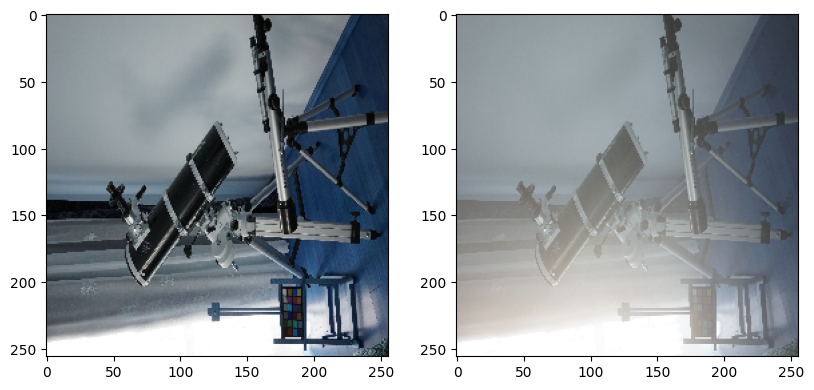

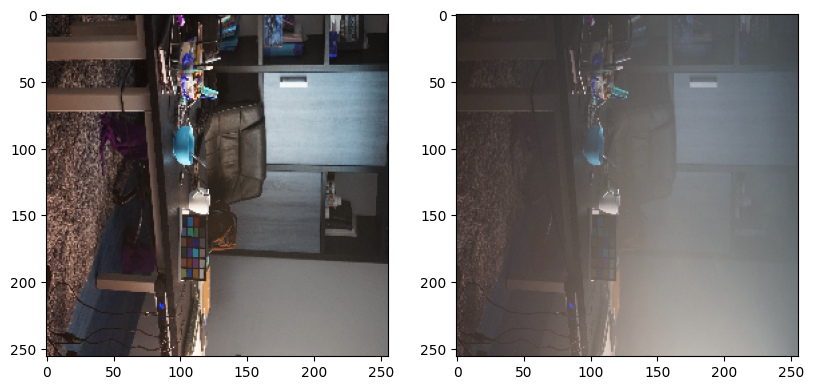

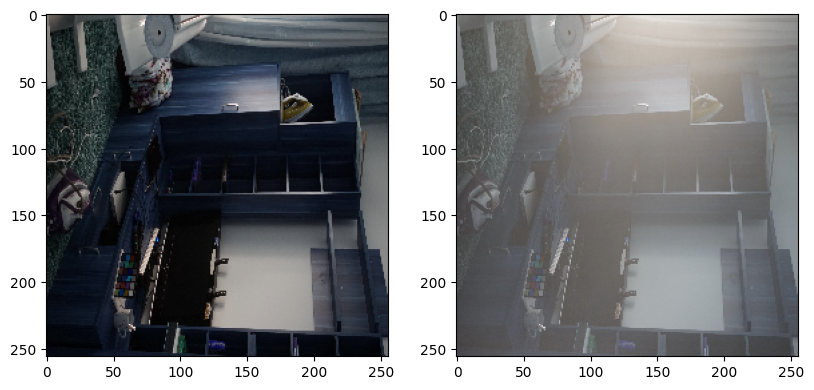

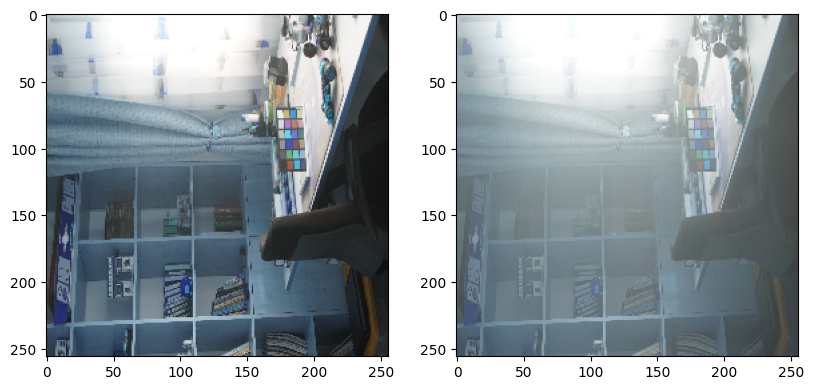

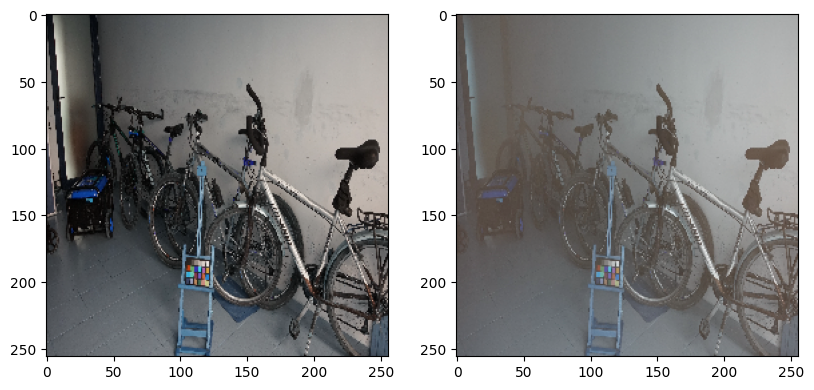

In [9]:
for i in range(0,len(patch),5):
    
    fig=plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(131)
    plt.imshow(patch[i])
    
    ax = plt.subplot(132)
    plt.imshow(mask[i])
    plt.show()

In [10]:
IMG_SIZE = 256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.0005

In [11]:


patch_loader = torch.utils.data.DataLoader(dataset=patch,batch_size=batch_size,shuffle=False)

for data in patch_loader:
    print(data.size())
    print(type(data))
    break



torch.Size([1, 256, 256, 3])
<class 'torch.Tensor'>


In [12]:
X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
X_hazy=torch.Tensor([mask[i] for i in range(len(mask))])

X_orig=X_orig/255
X_hazy=X_hazy/255

/tmp/ipykernel_4806/724504452.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_orig=torch.Tensor([patch[i] for i in range(len(patch))])


In [13]:
print('X_orig: ',X_orig.size())

X_orig_T=np.transpose(X_orig,(0,3,1,2))
X_hazy_T=np.transpose(X_hazy,(0,3,1,2))
print('X_orig_T: ',X_orig_T.shape)

X_orig_flat=X_orig_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_hazy_flat=X_hazy_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
print('X_orig_flat: ',X_orig_flat.shape)

X_orig:  torch.Size([25, 256, 256, 3])
X_orig_T:  torch.Size([25, 3, 256, 256])
X_orig_flat:  torch.Size([75, 1, 256, 256])


In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()


In [16]:
# Check output of encoder-decoder

train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([1, 1, 256, 256])
Hazy Image Dim:  torch.Size([1, 1, 256, 256])
Encoder Output Dim:  torch.Size([1, 1048576])
Output Dim:  torch.Size([1, 1, 256, 256])


In [17]:
# In order to use multi parameters with one optimizer, concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
losses=[]
X_orig1=X_orig

for epoch in tqdm(range(EPOCHS)):
    
    rand_idx=torch.randperm(X_orig1.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_hazy_iter=X_hazy[rand_idx]

    X_orig_iter1=np.transpose(X_orig_iter,(0,3,1,2))
    X_hazy_iter1=np.transpose(X_hazy_iter,(0,3,1,2))

    X_orig_iter2=X_orig_iter1.reshape(-1,1,IMG_SIZE,IMG_SIZE)
    X_hazy_iter2=X_hazy_iter1.reshape(-1,1,IMG_SIZE,IMG_SIZE)

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter2,batch_size=batch_size,shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter2,batch_size=batch_size,shuffle=False)

    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()
        
        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)
        
        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()

    losses.append(loss)
    
torch.save([encoder,decoder],'dehaze_autoencoder.pkl')

100%|██████████| 1000/1000 [13:01<00:00,  1.28it/s]


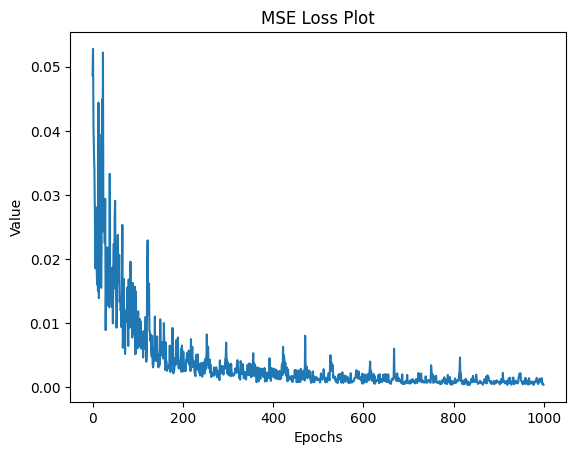

In [18]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
losses_np = [loss.cpu().detach().numpy() for loss in losses]  # Detach tensor before converting to numpy array
plt.plot(losses_np)
plt.show()

In [19]:
encoder, decoder = torch.load('dehaze_autoencoder.pkl')

In [20]:
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for train_hazy in tqdm(train_hazy_loader):
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

100%|██████████| 75/75 [00:00<00:00, 263.89it/s]


In [21]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)


torch.Size([75, 1, 1, 256, 256])
torch.Size([75, 1, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


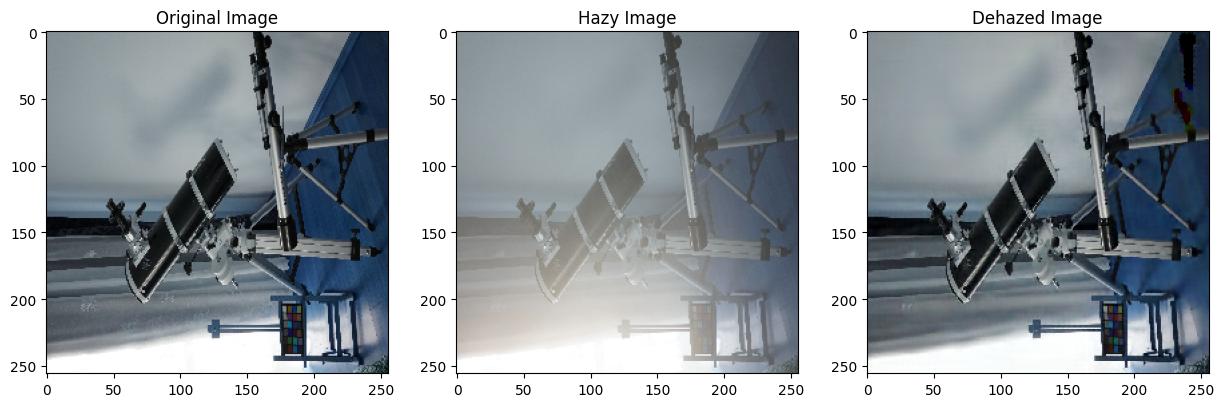

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


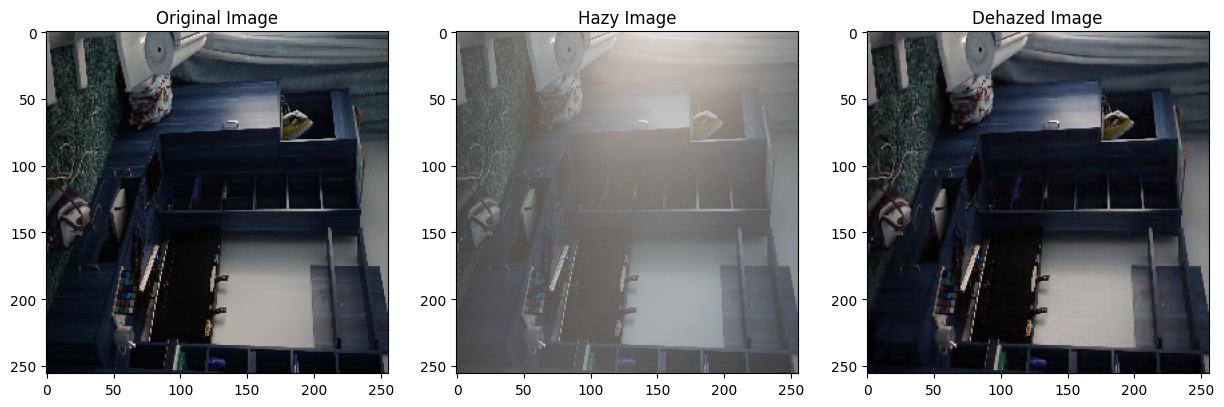

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


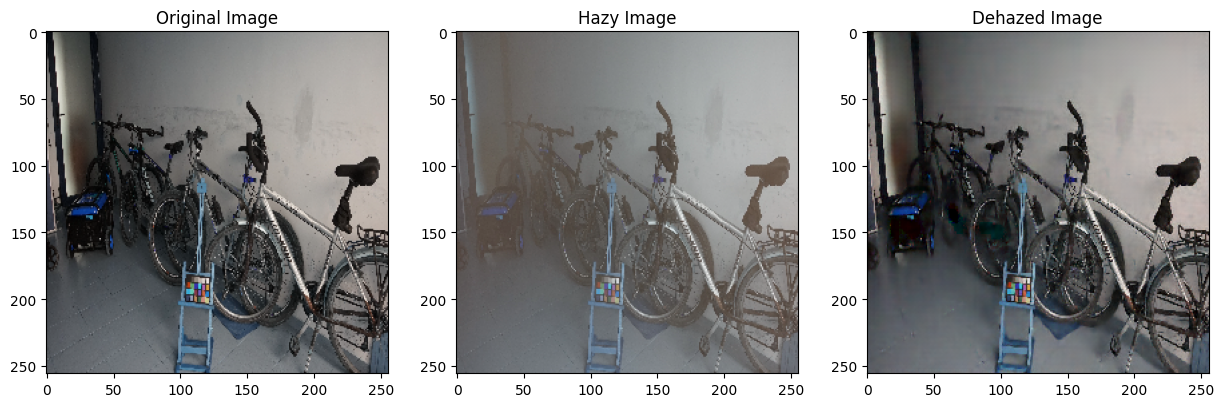

In [22]:
for i in range(0,len(X_orig),10):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])
    
    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

In [23]:
X_dehazed=X_dehazed.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_orig
res_mat=X_dehazed

print(ref_mat.shape)
print(res_mat.shape)

(25, 256, 256, 3)
(25, 256, 256, 3)


In [24]:
# ref_mat = ref_mat.astype('float') / 255.0
# res_mat = res_mat.astype('float') / 255.0

# def output_psnr_mse(img_orig, img_out):
#     squared_error = np.square(img_orig - img_out)
#     mse = np.mean(squared_error)
#     psnr = 10 * np.log10(1.0 / mse)
#     return psnr

# def mean_psnr_srgb(ref_mat, res_mat):
#     n_blk, h, w, c = ref_mat.shape
#     mean_psnr = 0
#     for b in range(n_blk):
#         ref_block = ref_mat[b, :, :, :]
#         res_block = res_mat[b, :, :, :]
#         ref_block = np.reshape(ref_block, (h, w, c))
#         res_block = np.reshape(res_block, (h, w, c))
#         psnr = output_psnr_mse(ref_block, res_block)
#         mean_psnr += psnr
#     return mean_psnr / n_blk

# #PSNR
# mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
# print('mean_psnr:')
# print(mean_psnr)

ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

mean_psnr:
31.56919722550967


In [32]:
import numpy as np

def ssim_index(img1, img2, L=255):
    # Constants for SSIM calculation
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2
    
    # Mean and variance of images
    mu1 = np.mean(img1, axis=(1, 2), keepdims=True)
    mu2 = np.mean(img2, axis=(1, 2), keepdims=True)
    sigma1_sq = np.var(img1, axis=(1, 2), keepdims=True)
    sigma2_sq = np.var(img2, axis=(1, 2), keepdims=True)
    sigma12 = np.mean((img1 * img2), axis=(1, 2), keepdims=True) - mu1 * mu2
    
    # SSIM formula
    num = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    den = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_map = num / den
    
    # Compute mean SSIM
    return np.mean(ssim_map, axis=(1, 2))

def mean_ssim_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_ssim = 0
    for b in range(n_blk):
        ref_block = ref_mat[b]
        res_block = res_mat[b]
        ssim1 = ssim_index(ref_block, res_block)
        mean_ssim += ssim1
    return mean_ssim / n_blk

# Example usage
ref_mat = np.random.rand(25, 256, 256, 3)
res_mat = np.random.rand(25, 256, 256, 3)
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)


mean_ssim:
[0.99712046 0.99711835 0.99712679 0.9971095  0.99712082 0.99714315
 0.99708204 0.99710031 0.99717739 0.9970999  0.99714446 0.99712161
 0.99707213 0.99715627 0.99720201 0.99713251 0.99715496 0.99712776
 0.99716677 0.9970795  0.99708901 0.99711917 0.99712526 0.99714263
 0.99710496 0.9971678  0.99714058 0.99714147 0.99711506 0.99714748
 0.99712969 0.99715964 0.99716028 0.99717043 0.99717933 0.9971422
 0.99713392 0.99708409 0.99712561 0.99708361 0.99713453 0.99713288
 0.99712059 0.99713437 0.99715302 0.99712111 0.99713172 0.99711786
 0.99714772 0.99714192 0.9971118  0.99712629 0.99710081 0.99707283
 0.99712127 0.99711228 0.99710318 0.99711763 0.99710195 0.99714366
 0.99710538 0.99714721 0.99716297 0.99714376 0.99713766 0.99714955
 0.99713555 0.9971583  0.99718469 0.9971519  0.9971383  0.9971283
 0.997146   0.99715891 0.99710311 0.99711477 0.99711066 0.99714292
 0.99717447 0.99711715 0.99708877 0.99715047 0.99713696 0.99712126
 0.99714833 0.99707598 0.99714837 0.99709695 0.997124